In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision import models
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import copy
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import seaborn as sns

In [2]:
def check_and_print_directory(path):
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return False
    
    for dirpath, dirnames, filenames in os.walk(path):
        level = dirpath.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(dirpath)}/')
        subindent = ' ' * 4 * (level + 1)
    return True

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define paths
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

# Check and print directory contents
print("Checking training directory:")
if not check_and_print_directory(train_dir):
    raise FileNotFoundError(f"Training directory not found: {train_dir}")

print("\nChecking validation directory:")
if not check_and_print_directory(val_dir):
    raise FileNotFoundError(f"Validation directory not found: {val_dir}")

print("\nChecking test directory:")
if not check_and_print_directory(test_dir):
    raise FileNotFoundError(f"Test directory not found: {test_dir}")



transform = transforms.Compose([
    transforms.Resize((120, 80)),  # Gör om storleken till 100x100
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Checking training directory:
train/
    NORMAL/
        .ipynb_checkpoints/
    PNEUMONIA/
        .ipynb_checkpoints/

Checking validation directory:
val/
    NORMAL/
    PNEUMONIA/

Checking test directory:
test/
    NORMAL/
    PNEUMONIA/


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the

Epoch 1: Train Loss: 0.1702, Validation Loss: 0.2079, Val Accuracy: 0.9111, Val F1 Score: 0.9184
Epoch 2: Train Loss: 0.0586, Validation Loss: 0.0726, Val Accuracy: 0.9556, Val F1 Score: 0.9574
Epoch 3: Train Loss: 0.0455, Validation Loss: 0.0658, Val Accuracy: 0.9667, Val F1 Score: 0.9663
Epoch 4: Train Loss: 0.0282, Validation Loss: 0.0985, Val Accuracy: 0.9444, Val F1 Score: 0.9474
Epoch 5: Train Loss: 0.0063, Validation Loss: 0.0563, Val Accuracy: 0.9889, Val F1 Score: 0.9890
Epoch 6: Train Loss: 0.0256, Validation Loss: 0.1310, Val Accuracy: 0.9444, Val F1 Score: 0.9462
Epoch 7: Train Loss: 0.0147, Validation Loss: 0.1422, Val Accuracy: 0.9444, Val F1 Score: 0.9474
Epoch 8: Train Loss: 0.0229, Validation Loss: 0.0487, Val Accuracy: 0.9889, Val F1 Score: 0.9890
Epoch 9: Train Loss: 0.0160, Validation Loss: 0.0406, Val Accuracy: 0.9778, Val F1 Score: 0.9773
Epoch 10: Train Loss: 0.0063, Validation Loss: 0.1358, Val Accuracy: 0.9556, Val F1 Score: 0.9556
Epoch 11: Train Loss: 0.0066,

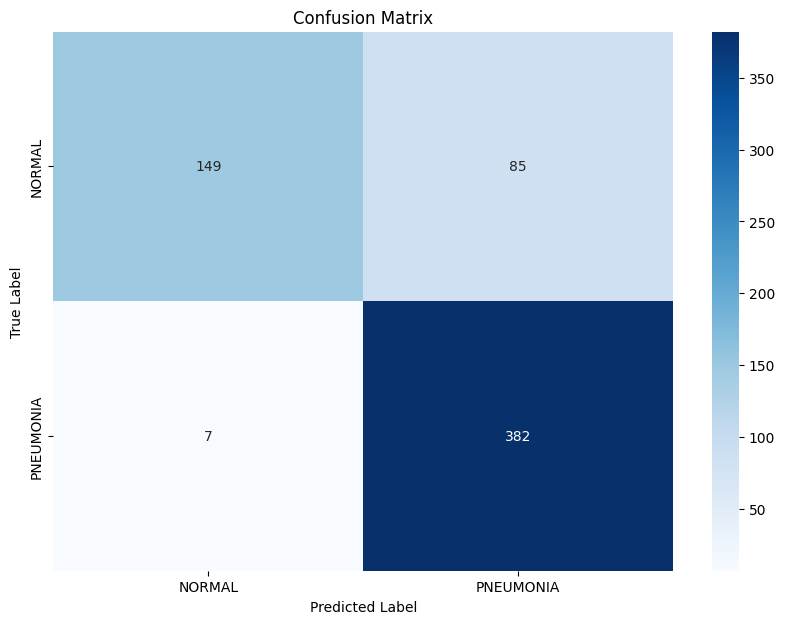

In [3]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
for param in model.features.denseblock4.parameters():
    param.requires_grad = True
for param in model.features.transition3.parameters():
    param.requires_grad = True

num_features = model.classifier.in_features
nn.Flatten()
model.classifier = nn.Linear(num_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

 # Training
def train_model(model, train_loader, val_loader, num_epochs, patience):
    best_model = None
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted_train = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted_train.eq(labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = correct_train / total_train


        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy, val_f1 = accuracy_score(all_labels, all_preds), f1_score(all_labels, all_preds)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}")
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
        

def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    
    # Print accuracy and F1 score
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, train_dataset.classes)




def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()




train_model(model, train_loader, val_loader, num_epochs=15, patience=5)

print()

evaluate_model(model, test_loader)
